# **Connect to Github and Download dataset**

In [1]:
#!git clone https://github.com/2black0/sound-emotion-recognition-javanese.git

Cloning into 'sound-emotion-recognition-javanese'...
remote: Enumerating objects: 1697, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 1697 (delta 1), reused 6 (delta 0), pack-reused 1687
Receiving objects: 100% (1697/1697), 124.20 MiB | 26.08 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (1686/1686), done.


# **Check Dataset**

In [28]:
import os
rootdir = os.getcwd()
dirdataset = rootdir+"/dataset"

In [29]:
%cd $dirdataset

/home/ubuntu/Documents/GitHub/sound-emotion-recognition-javanese/dataset


In [30]:
%pwd

'/home/ubuntu/Documents/GitHub/sound-emotion-recognition-javanese/dataset'

In [ ]:
!ls

# **Check the train and test file**

In [32]:
dirmodel = rootdir+"/model"
%cd $dirmodel

/home/ubuntu/Documents/GitHub/sound-emotion-recognition-javanese/model


In [33]:
!ls -l

total 592
-rw-rw-r-- 1 ubuntu ubuntu 134528 Jul 22 05:59 x_test.npy
-rw-rw-r-- 1 ubuntu ubuntu 403008 Jul 22 05:59 x_train.npy
-rw-rw-r-- 1 ubuntu ubuntu  15248 Jul 22 05:59 y_test.npy
-rw-rw-r-- 1 ubuntu ubuntu  45452 Jul 22 05:59 y_train.npy


# **Training & Testing**

Perhatikan komentar di atas kode sebelum di-run

In [34]:
#load module used
import os
import re
import glob
import pickle
import soundfile
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import matplotlib.pyplot as plt

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [36]:
#get the all file
def getListOfFiles(dirName):
  listOfFile = os.listdir(dirName)
  allFiles = list()
  for entry in listOfFile:
    fullPath = os.path.join(dirName, entry)
    if os.path.isdir(fullPath):
      allFiles = allFiles + getListOfFiles(fullPath)
    else:
      allFiles.append(fullPath)      
  return allFiles

In [37]:
#list of all the file, change dirName to directory of the dataset used
listOfFiles = getListOfFiles(dirdataset)

In [ ]:
print(listOfFiles)

In [39]:
#feature extraction using mfcc, chroma, and mel
def feature_extractor(file, mfcc, chroma, mel):
  with soundfile.SoundFile(file) as sound_file:
    file_array = sound_file.read(dtype="float32")
    sample_rate=sound_file.samplerate
    result=np.array([])
    if mfcc:
      mfccs=np.mean(librosa.feature.mfcc(y=file_array, sr=sample_rate, n_mfcc=40).T, axis=0)
      result=np.hstack((result, mfccs))
    if chroma:
      stft=np.abs(librosa.stft(file_array))
      chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
      result=np.hstack((result, chroma))
    if mel:
      mel=np.mean(librosa.feature.melspectrogram(file_array, sr=sample_rate).T,axis=0)
      result=np.hstack((result, mel))
  return result

In [40]:
#list of emotion 
emotions={
        '01':'neutral',
        '02':'sad',
        '03':'happy',
        '04':'surprised',
        '05':'fearful',
        '06':'angry',
        }

observed_emotions=['neutral', 'sad', 'happy', 'surprised', 'fearful', 'angry']

In [ ]:
#pastikan tercetak 3 data:
# -path lengkap dari file dataset (contoh: /content/drive/MyDrive/Colab/penelitian-kln/clean-dataset/04-01-06_02.wav)
# -nama file (contoh: 04-01-06_02.wav)
# -emotion(contoh: angry)

for file in listOfFiles:
  #print(file)
  file_name=os.path.basename(file)
  emotion=emotions[re.split("-|_", file_name)[2]]
  print('file:{} file_name:{} emotion:{}'.format(file, file_name, emotion))

In [42]:
def data_loarder(listOfFiles, test_size=0.25):
  x,y=[],[]
  for file in listOfFiles:
    file_name=os.path.basename(file)
    emotion=emotions[re.split("-|_", file_name)[2]]
    if emotion not in observed_emotions:
      continue
    feature=feature_extractor(file, mfcc=True, chroma=False, mel=False)
    x.append(feature)
    y.append(emotion)
  return train_test_split(np.array(x), y, test_size=test_size)

___

## **PERHATIAN**: 

Apabila sudah terdapat file x_test.npy  x_train.npy  y_test.npy  y_train.npy pada folder model tidak perlu menjalankan cell ini

In [ ]:
#cukup jalankan 1x saja apabila file2 di bawah ini belum ada
x_train, x_test, y_train, y_test = data_loarder(listOfFiles, test_size=0.25)

%cd /home/ubuntu/Documents/GitHub/sound-emotion-recognition-javanese/model
np.save('x_train.npy', x_train)
np.save('x_test.npy', x_test)
np.save('y_train.npy', y_train)
np.save('y_test.npy', y_test)

____

**PERHATIAN**: Apabila pada bagian ini error, silahkan jalankan kode di atas dan pastikan sudah terdapat file *x_test.npy x_train.npy y_test.npy y_train.npy pada folder model

In [44]:
%cd $dirmodel
x_trains = np.load('x_train.npy')
x_tests = np.load('x_test.npy')
y_trains = np.load('y_train.npy')
y_tests = np.load('y_test.npy')

/home/ubuntu/Documents/GitHub/sound-emotion-recognition-javanese/model


In [45]:
#menghitung persebaran dataset yang ada pada train dan test pada masing2 label
emotions, counts = np.unique(y_trains, return_counts=True)
print('label train:', dict(zip(emotions, counts)))

emotions, counts = np.unique(y_tests, return_counts=True)
print('label test:', dict(zip(emotions, counts)))

label train: {'angry': 196, 'fearful': 219, 'happy': 213, 'neutral': 208, 'sad': 216, 'surprised': 207}
label test: {'angry': 84, 'fearful': 61, 'happy': 66, 'neutral': 72, 'sad': 64, 'surprised': 73}


In [87]:
#beberapa algoritma untuk klasifikasi
classifiers = [
    KNeighborsClassifier(),
    SVC(kernel="linear", C=0.025),
    RandomForestClassifier(max_depth=5, random_state=43),
    MLPClassifier(alpha=0.01, max_iter=1000),
    QuadraticDiscriminantAnalysis()]

In [88]:
names = ["Nearest Neighbors", "Linear SVC", "Random Forest", "Neural Net", "QDA"]

In [89]:
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(x_trains, y_trains)
    score = clf.score(x_tests, y_tests)
    print(f"Accuracy of {name} Classifier is:{score}")

Accuracy of Nearest Neighbors Classifier is:0.8119047619047619
Accuracy of Linear SVC Classifier is:0.7214285714285714
Accuracy of Random Forest Classifier is:0.6952380952380952
Accuracy of Neural Net Classifier is:0.8452380952380952
Accuracy of QDA Classifier is:0.8642857142857143


# **Hyper Parameter Tuning**

## Neural Network Hyperparameter

In [49]:
import optuna

In [ ]:
def objective(trial):
    layers = trial.suggest_categorical('layers',[1,2])
    h1 = trial.suggest_int('h1',10,500)
    max_i = trial.suggest_int('max_i',10,1000)
    lr_init = trial.suggest_uniform('lr',0.00001,0.1)
    ni = trial.suggest_int('noi',10,30)
    #act = trial.suggest_categorical('activation',['identity', 'logistic', 'tanh', 'relu'])
    #sol = trial.suggest_categorical('solver',['lbfgs', 'sgd', 'adam'])
    
    if layers==1:
        clf = MLPClassifier(random_state=11,
                            hidden_layer_sizes=(h1),
                            max_iter=max_i, 
                            learning_rate_init=lr_init,
                            n_iter_no_change=ni)
                            #activation=act,
                            #solver=sol)
    else:
        h2 = trial.suggest_int('h2',10,500)
        clf = MLPClassifier(random_state=11,
                            hidden_layer_sizes=(h1,h2),
                            max_iter=max_i, 
                            learning_rate_init=lr_init,
                            n_iter_no_change=ni)
                            #activation=act,
                            #solver=sol)
    
    #clf.fit(x_trains, y_trains)
    #return clf.score(x_tests, y_tests)
    score = cross_val_score(clf, x_trains, y_trains, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)
print(study.best_params)

{'layers': 2, 'h1': 406, 'max_i': 679, 'lr': 6.885053259405357e-05, 'noi': 25, 'h2': 374}

In [50]:
classifier = MLPClassifier(learning_rate_init=6.885053259405357e-05, max_iter=679, n_iter_no_change=25, hidden_layer_sizes=(406,374))

classifier.fit(x_trains, y_trains)
score = classifier.score(x_tests, y_tests)
print(f"Accuracy of Neural Network Classifier is:{score}")

Accuracy of Neural Network Classifier is:0.8976190476190476


/home/ubuntu/miniconda3/envs/kln/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (679) reached and the optimization hasn't converged yet.
  warnings.warn(


## KNN Hyperparameter

In [ ]:
def objective(trial):
    optimizer = trial.suggest_categorical('algorithm', ['auto','ball_tree','kd_tree','brute'])
    rf_max_depth = trial.suggest_int("k_n_neighbors", 2, 15, log=True)
    clf = KNeighborsClassifier(algorithm=optimizer, n_neighbors=rf_max_depth)

    score = cross_val_score(clf, x_trains, y_trains, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

    #classifier_obj.fit(x_trains, y_trains)
    #return classifier_obj.score(x_tests, y_tests)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)
print(study.best_params)

In [51]:
classifier = KNeighborsClassifier(algorithm='kd_tree', n_neighbors=3)

classifier.fit(x_trains, y_trains)
score = classifier.score(x_tests, y_tests)
print(f"Accuracy of KNeighbors Classifier is:{score}")

Accuracy of KNeighbors Classifier is:0.8261904761904761


## SVM Hyperparameter

In [ ]:
def objective(trial):
    #kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly'])
    regularization = trial.suggest_uniform('svm-regularization', 0.01, 10)
    degree = trial.suggest_discrete_uniform('degree', 1, 5, 1)
    clf = SVC(kernel=kernel, C=regularization, degree=degree)

    score = cross_val_score(clf, x_trains, y_trains, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)
print(study.best_params)

In [53]:
#classifier = SVC(kernel='linear', C=1.4965680888866226, degree=1.0)
classifier = SVC(kernel='linear', C=1.4873029879624768, degree=2.0)

classifier.fit(x_trains, y_trains)
score = classifier.score(x_tests, y_tests)
print(f"Accuracy of SVM Classifier is:{score}")

Accuracy of SVM Classifier is:0.7166666666666667


## Random Forest Hyperparameter

In [ ]:
def objective(trial):
    rf_n_estimators = trial.suggest_int("rf_n_estimators", 10, 1000)
    rf_max_depth = trial.suggest_int("rf_max_depth", 2, 32, log=True)
    classifier_obj = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_n_estimators)

    score = cross_val_score(clf, x_trains, y_trains, n_jobs=-1, cv=3)
    accuracy = score.mean()
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)
print(study.best_params)

In [54]:
classifier = RandomForestClassifier(max_depth=8, n_estimators=90)

classifier.fit(x_trains, y_trains)
score = classifier.score(x_tests, y_tests)
print(f"Accuracy of Random Forest Classifier is:{score}")

Accuracy of Random Forest Classifier is:0.8142857142857143


_____

# **Report**

## Kearest Neighbors Classifier

In [105]:
#cetak precision, recall, f1-score, dan support dari Nearest Neighbors Classifier
y_pred=classifiers[0].predict(x_tests)

print("Classification Report of KNearest Neighbors Classifier")
print("Accuracy = %0.2f" % accuracy_score(y_tests, y_pred))
print(classification_report(y_tests, y_pred))

Classification Report of KNearest Neighbors Classifier
Accuracy = 0.81
              precision    recall  f1-score   support

       angry       0.94      0.90      0.92        84
     fearful       0.66      0.90      0.76        61
       happy       0.74      0.79      0.76        66
     neutral       0.89      0.90      0.90        72
         sad       0.80      0.70      0.75        64
   surprised       0.84      0.66      0.74        73

    accuracy                           0.81       420
   macro avg       0.81      0.81      0.81       420
weighted avg       0.82      0.81      0.81       420



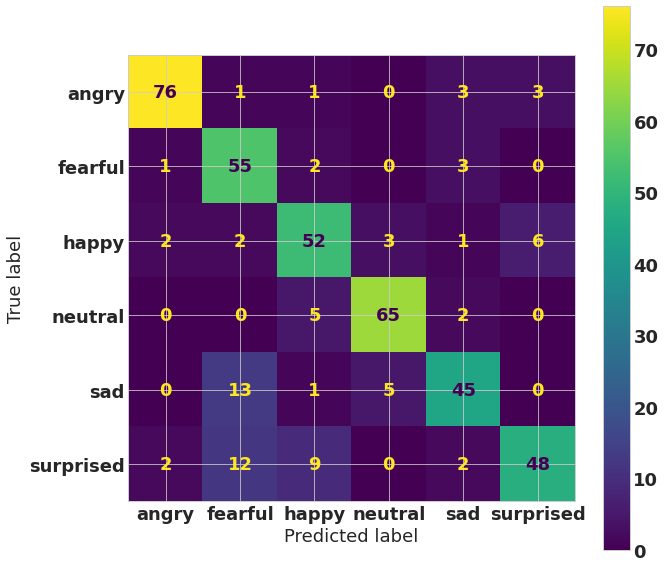

In [106]:
#plot confusion matrix Nearest Neighbors Classifier
cm = confusion_matrix(y_tests, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=classifiers[0].classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

## Linear SVC

In [107]:
#cetak precision, recall, f1-score, dan support dari Linear SVC Classifier
y_pred=classifiers[1].predict(x_tests)

print("Classification Report of Linear SVC Classifier")
print("Accuracy = %0.2f" % accuracy_score(y_tests, y_pred))
print(classification_report(y_tests, y_pred))

Classification Report of Linear SVC Classifier
Accuracy = 0.72
              precision    recall  f1-score   support

       angry       0.79      0.88      0.83        84
     fearful       0.61      0.66      0.63        61
       happy       0.63      0.68      0.66        66
     neutral       0.89      0.88      0.88        72
         sad       0.66      0.59      0.62        64
   surprised       0.72      0.59      0.65        73

    accuracy                           0.72       420
   macro avg       0.71      0.71      0.71       420
weighted avg       0.72      0.72      0.72       420



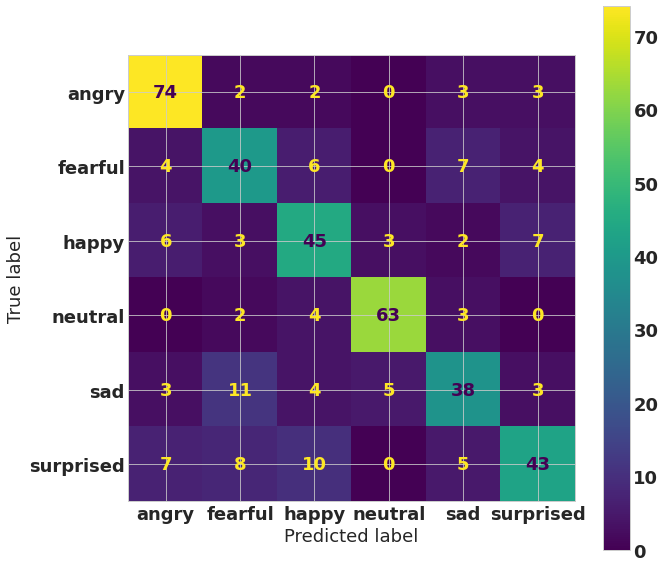

In [108]:
#plot confusion matrix Nearest Neighbors Classifier
cm = confusion_matrix(y_tests, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=classifiers[1].classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

## Random Forest

In [109]:
#cetak precision, recall, f1-score, dan support dari Random Forest Classifier
y_pred=classifiers[2].predict(x_tests)

print("Classification Report of Random Forest Classifier")
print("Accuracy = %0.2f" % accuracy_score(y_tests, y_pred))
print(classification_report(y_tests, y_pred))

Classification Report of Random Forest Classifier
Accuracy = 0.70
              precision    recall  f1-score   support

       angry       0.78      0.87      0.82        84
     fearful       0.59      0.62      0.61        61
       happy       0.66      0.53      0.59        66
     neutral       0.78      0.86      0.82        72
         sad       0.69      0.69      0.69        64
   surprised       0.62      0.55      0.58        73

    accuracy                           0.70       420
   macro avg       0.68      0.69      0.68       420
weighted avg       0.69      0.70      0.69       420



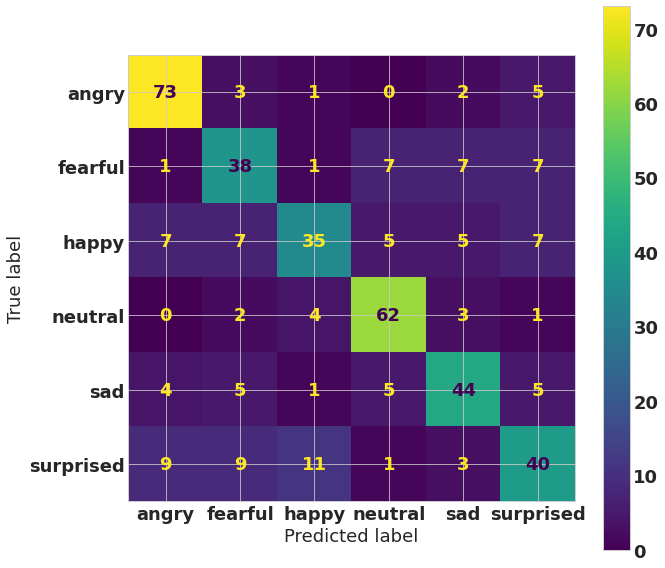

In [110]:
#plot confusion matrix Nearest Neighbors Classifier
cm = confusion_matrix(y_tests, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=classifiers[2].classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

## Neural Network

In [112]:
#cetak precision, recall, f1-score, dan support dari Neural Network Classifier
y_pred=classifiers[3].predict(x_tests)

print("Classification Report of Neural Network Classifier")
print("Accuracy = %0.2f" % accuracy_score(y_tests, y_pred))
print(classification_report(y_tests, y_pred))

Classification Report of Neural Network Classifier
Accuracy = 0.85
              precision    recall  f1-score   support

       angry       0.93      0.85      0.89        84
     fearful       0.87      0.75      0.81        61
       happy       0.71      0.92      0.80        66
     neutral       0.97      0.92      0.94        72
         sad       0.79      0.89      0.84        64
   surprised       0.83      0.74      0.78        73

    accuracy                           0.85       420
   macro avg       0.85      0.85      0.84       420
weighted avg       0.86      0.85      0.85       420



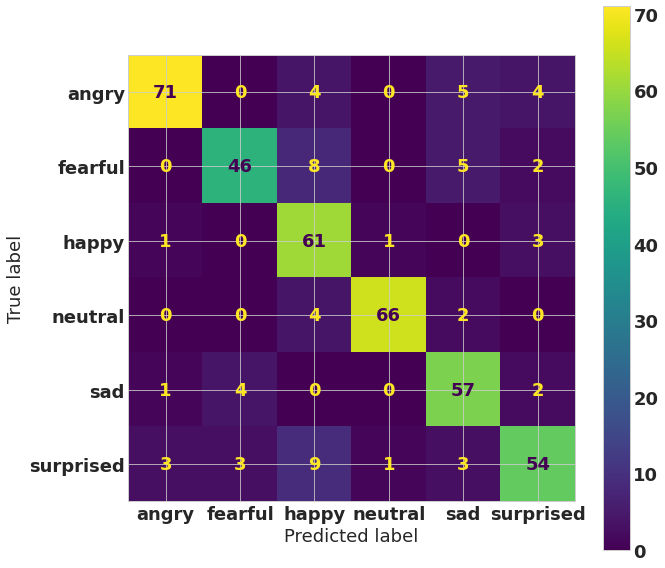

In [113]:
#plot confusion matrix Nearest Neighbors Classifier
cm = confusion_matrix(y_tests, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=classifiers[3].classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

## QDA Classifier

In [114]:
#cetak precision, recall, f1-score, dan support dari QDA Classifier
y_pred=classifiers[4].predict(x_tests)

print("Classification Report of QDA Classifier ")
print("Accuracy = %0.2f" % accuracy_score(y_tests, y_pred))
print(classification_report(y_tests, y_pred))

Classification Report of QDA Classifier 
Accuracy = 0.86
              precision    recall  f1-score   support

       angry       0.88      0.90      0.89        84
     fearful       0.91      0.79      0.84        61
       happy       0.90      0.83      0.87        66
     neutral       0.95      0.97      0.96        72
         sad       0.81      0.80      0.80        64
   surprised       0.76      0.86      0.81        73

    accuracy                           0.86       420
   macro avg       0.87      0.86      0.86       420
weighted avg       0.87      0.86      0.86       420



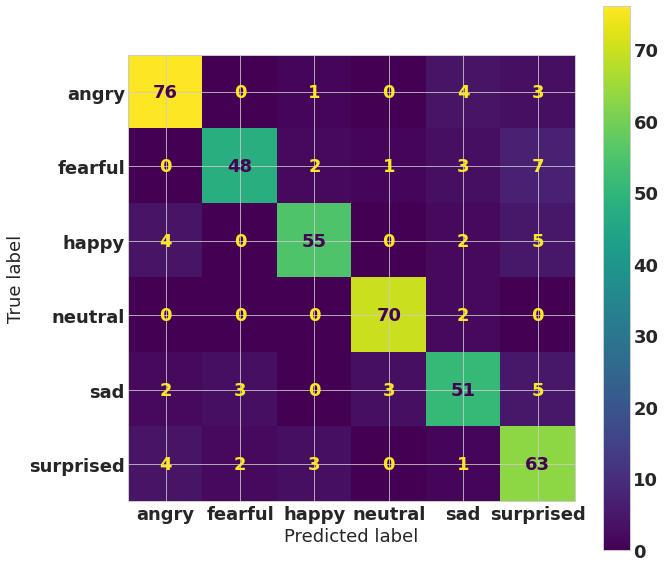

In [115]:
#plot confusion matrix Nearest Neighbors Classifier
cm = confusion_matrix(y_tests, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels=classifiers[4].classes_)
fig, ax = plt.subplots(figsize=(10,10))
cmp.plot(ax=ax)

# **Import Model**

Bagian ini digunakan untuk menyimpan model hasil training

In [117]:
import pickle

In [118]:
#change directory
%cd $dirmodel

/home/ubuntu/Documents/GitHub/sound-emotion-recognition-javanese/model


In [120]:
# save the model to disk
filename = 'final_model_NeuralNetwork.sav'
pickle.dump(classifiers[3], open(filename, 'wb'))

# **Test the Model**

Bagian ini untuk meload file model agar bisa digunakan untuk prediksi

In [122]:
# load the model from disk
filename = 'final_model_NeuralNetwork.sav'

loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(x_tests, y_tests)
print(result)

0.8452380952380952


**Penamaan File**

*aa-bb-cc-dd.wav*

- aa -> Aktor 01-10
- bb -> Kalimat 01-04
- cc -> Ekspresi 01-06
- dd -> Pengulanan 01-07

Eskpresi:
- 01 - Neutral / Biasa
- 02 - Sadness / Susah
- 03 - Happiness / Seneng
- 04 - Surprise / Kaget
- 05 - Fear / Wedi
- 06 - Anger / Ness

contoh:
*01-02-03-04.wav*

- 01 -> Aktor 01
- 02 -> Kalimat ke-02
- 03 -> Ekspresi ke-03
- 04 -> Pengulanan ke-04

In [123]:
#feature extraction dari file yang akan di uji / di prediksi
x = []
file_test = dirdataset+"/01-03-02_04.wav"
feature=feature_extractor(file_test, mfcc=True, chroma=False, mel=False)
x.append(feature)

In [124]:
#hasil prediksi berdasarkan model aktif
y=classifiers[3].predict(x)
print(y)

['sad']


In [125]:
#hasil prediksi berdasarkan file model
y_m = loaded_model.predict(x)
print(y_m)

['sad']
